In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from keras.datasets import mnist

%matplotlib inline

In [11]:
(train_X,train_y),(test_X,test_y) = mnist.load_data()
train_X.shape

(60000, 28, 28)

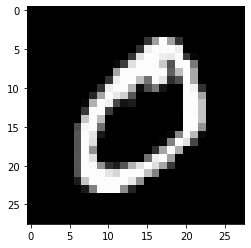

In [13]:
plt.imshow(train_X[1],cmap='gray')

In [19]:
train_y

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [20]:
#normalize and reshaping our X data
train_X = train_X.reshape(-1,28,28,1)
test_X  = test_X.reshape(-1,28,28,1)

train_X = train_X.astype('float32')
test_X  = test_X.astype('float32')

train_X = train_X/255
test_X  = test_X/255

#one hot encode our y data
from keras.utils import np_utils 
train_y = np_utils.to_categorical(train_y)
test_y  = np_utils.to_categorical(test_y)

In [24]:
train_y[1]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [28]:
#creating our model
input_shape=(28,28,1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Flatten,Dropout,Dense,MaxPooling2D
from tensorflow.keras.optimizers import SGD
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape,padding='SAME'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3),activation='relu',padding='SAME'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10,activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(0.01),
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               4

In [29]:
# training our data
batch_size=32
epochs=10

plotting_data = model.fit(train_X,
                          train_y,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          validation_data=(test_X,test_y))

loss,accuracy = model.evaluate(test_X,test_y,verbose=0)

print('Test loss ---> ',str(round(loss*100,2)) +str('%'))
print('Test accuracy ---> ',str(round(accuracy*100,2)) +str('%'))

Epoch 1/10
1875/1875 [==============================] - 45s 23ms/step - loss: 0.7481 - accuracy: 0.7566 - val_loss: 0.1798 - val_accuracy: 0.9465
Epoch 2/10
1875/1875 [==============================] - 44s 24ms/step - loss: 0.2581 - accuracy: 0.9222 - val_loss: 0.1118 - val_accuracy: 0.9641
Epoch 3/10
1875/1875 [==============================] - 46s 25ms/step - loss: 0.1861 - accuracy: 0.9439 - val_loss: 0.0840 - val_accuracy: 0.9727
Epoch 4/10
1875/1875 [==============================] - 46s 25ms/step - loss: 0.1524 - accuracy: 0.9541 - val_loss: 0.0777 - val_accuracy: 0.9739
Epoch 5/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.1310 - accuracy: 0.9602 - val_loss: 0.0627 - val_accuracy: 0.9793
Epoch 6/10
1875/1875 [==============================] - 44s 24ms/step - loss: 0.1173 - accuracy: 0.9646 - val_loss: 0.0538 - val_accuracy: 0.9821
Epoch 7/10
1875/1875 [==============================] - 44s 24ms/step - loss: 0.1093 - accuracy: 0.9669 - val_loss: 0.0499 -

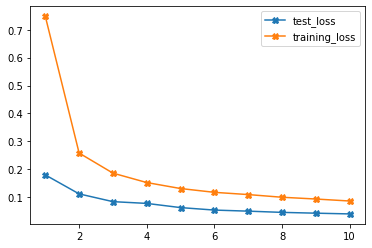

In [30]:
plotting_data_dict = plotting_data.history

test_loss = plotting_data_dict['val_loss']
training_loss = plotting_data_dict['loss']
test_accuracy = plotting_data_dict['val_accuracy']
training_accuracy = plotting_data_dict['accuracy']

epochs = range(1,len(test_loss)+1)

plt.plot(epochs,test_loss,marker='X',label='test_loss')
plt.plot(epochs,training_loss,marker='X',label='training_loss')
plt.legend()

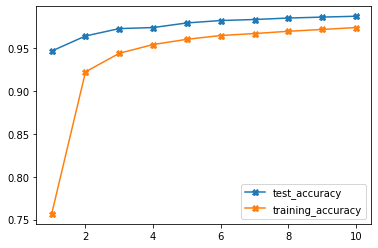

In [31]:
plt.plot(epochs,test_accuracy,marker='X',label='test_accuracy')
plt.plot(epochs,training_accuracy,marker='X',label='training_accuracy')
plt.legend()

In [32]:
model.save('MNIST_10_epochs.h5')
print('Model Saved !!!')

INFO:tensorflow:Assets written to: MNIST_10_epochs\assets
Model Saved !!!


In [3]:
classifier = load_model('MNIST_10_epochs.h5')

# live predictor


In [5]:
drawing=False
cv2.namedWindow('win')
black_image = np.zeros((256,256,3),np.uint8)
ix,iy=-1,-1

def draw_circles(event,x,y,flags,param):
    global ix,iy,drawing
    if event== cv2.EVENT_LBUTTONDOWN:
        drawing=True
        ix,iy=x,y
        
    elif event==cv2.EVENT_MOUSEMOVE:
        if drawing==True:
            cv2.circle(black_image,(x,y),5,(255,255,255),-1)
            
    elif event==cv2.EVENT_LBUTTONUP:
        drawing = False
        
cv2.setMouseCallback('win',draw_circles)

while True:
    cv2.imshow('win',black_image)
    if cv2.waitKey(1)==27:
        break
    elif cv2.waitKey(1)==13:
        input_img = cv2.resize(black_image,(28,28))
        input_img = cv2.cvtColor(input_img,cv2.COLOR_BGR2GRAY)
        input_img = input_img.reshape(1,28,28,1)
        res = classifier.predict_classes(input_img,1,verbose=0)[0]
        cv2.putText(black_image,text=str(res),org=(205,30),fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color=(255,255,255),thickness=2)
    elif cv2.waitKey(1)==ord('c'):
        black_image = np.zeros((256,256,3),np.uint8)
        ix,iy=-1,-1
cv2.destroyAllWindows()